# Timeseries_03-BuildFullModel

This is intended to load data prepared with the script `Timeseries_01-CompileInputData.R` and create a time series model predicting groundwater levels using the [`pastas`](https://pastas.readthedocs.io/en/latest/index.html) package.

It is based on parameters that seem best from experimentation in the Timeseries_02-PlayWithModels notebook.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## Load and check input data
We have data from three nested wells:
 - `LWPH4a` = shallow alluvial aquifer
 - `LWPH4b` = deep alluvial aquifer
 - `LWPH4c` = High Plains aquifer, separated from the alluvial aquifer by a (leaky?) confining layer.

We also have:
 - `stage_masl` = river stage elevation. This is `NaN` whenever flow in the river ceases.
 - `WaterUse_m3d` = estimated groundwater pumping within 4 km radius, based on uniform daily distribution of annual values.

The data type of the series is: <class 'pandas.core.frame.DataFrame'>
Variables are:  ['prcp_mm', 'tmax_c', 'tmin_c', 'ETo_mm', 'discharge_cms', 'stage_masl', 'WaterYear', 'WaterUse_m3d', 'LWPH4a', 'LWPH4a_source', 'LWPH4b', 'LWPH4b_source', 'LWPH4c', 'LWPH4c_source', 'regime_number', 'regime_category']


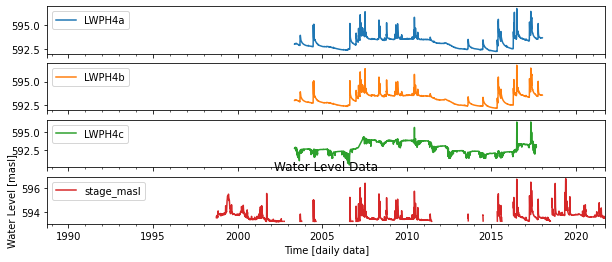

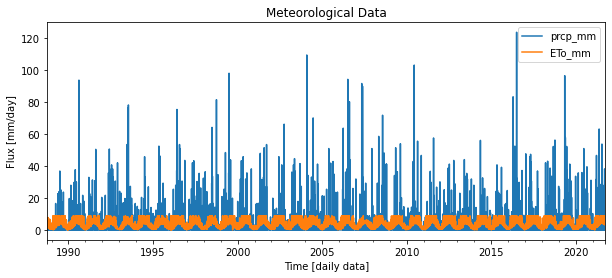

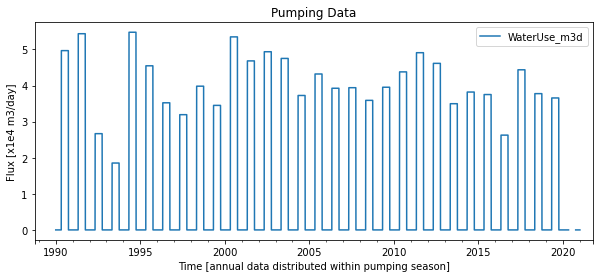

In [2]:
# Import input data time series and squeeze to Series object
inputdata = pd.read_csv('../data/Timeseries_InputData.csv', parse_dates=['date_ghcn'],
                        index_col='date_ghcn', squeeze=True)
print('The data type of the series is: %s' % type(inputdata))

# show names of columns
print('Variables are: ', list(inputdata))

# separate into water level data and meteorological data
hydrodata = inputdata[["LWPH4a", "LWPH4b", "LWPH4c", "stage_masl"]]
hydrodata.plot(figsize=(10, 4), subplots=True)
plt.title('Water Level Data');
plt.ylabel('Water Level [masl]');
plt.xlabel('Time [daily data]');

metdata = inputdata[["prcp_mm", "ETo_mm"]]
metdata.plot(figsize=(10, 4))
plt.title('Meteorological Data');
plt.ylabel('Flux [mm/day]');
plt.xlabel('Time [daily data]');

wusedata = inputdata[["WaterUse_m3d"]]/1e4
wusedata.plot(figsize=(10, 4))
plt.title('Pumping Data');
plt.ylabel('Flux [x1e4 m3/day]');
plt.xlabel('Time [annual data distributed within pumping season]');

## Build model

INFO: Nan-values were removed at the start of the time series LWPH4b.
INFO: Nan-values were removed at the end of the time series LWPH4b.
INFO: Inferred frequency for time series LWPH4b: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series ETo_mm: freq=D
INFO: Nan-values were removed at the start of the time series WaterUse_m3d.
INFO: Nan-values were removed at the end of the time series WaterUse_m3d.
INFO: Inferred frequency for time series WaterUse_m3d: freq=D
INFO: Time Series WaterUse_m3d: 153 nan-value(s) was/were found and filled with: 0.0.
INFO: Inferred frequency for time series stage_masl: freq=D
INFO: Nan-values were removed at the start of the time series LWPH4c.
INFO: Nan-values were removed at the end of the time series LWPH4c.
INFO: Inferred frequency for time series LWPH4c: freq=D
C:\ProgramData\Anaconda3\lib\site-packages\pastas\model.py:1658: RuntimeWarning: divide by zero encountered in log10
  atol = np.min([1e-8, 1

Fit report LWPH4b                         Fit Statistics
nfev    31                     EVP           89.45
nobs    5352                   R2             0.89
noise   True                   RMSE           0.20
tmin    2003-05-16 00:00:00    AIC       -35513.96
tmax    2018-01-08 00:00:00    BIC       -35441.52
freq    D                      Obj            3.50
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (11 optimized)
                    optimal   stderr      initial   vary
recharge_A         3.028052  ±16.82%     2.781326   True
recharge_a       595.230562  ±14.52%   709.070037   True
recharge_srmax   167.397835   ±6.75%   154.768736   True
recharge_lp        0.250000    ±nan%     0.250000  False
recharge_ks       27.339352  ±25.33%    47.503807   True
recharge_gamma     3.485625  ±13.48%     5.437437   True
recharge_simax     2.000000    ±nan%     2.000000  False
recharge_kv        1.000000    ±nan%     1.000000  F

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['WaterUse_m3d']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['stage_masl']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=11)'}>]

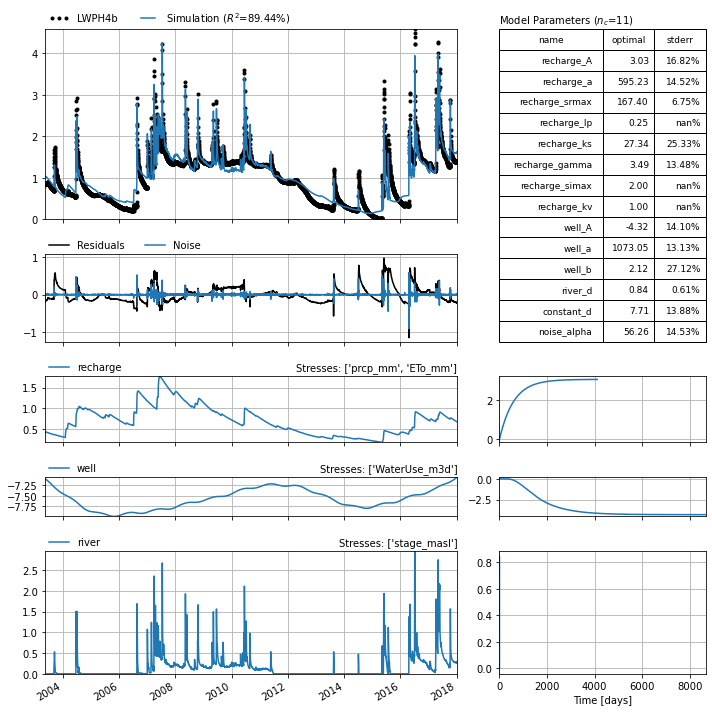

In [8]:
# normalize groundwater levels to min value
lwph4b = (hydrodata["LWPH4b"] - hydrodata["LWPH4b"].min()).asfreq("D")

# Create a model object by passing it the observed series
ml_lwph4b = ps.Model(lwph4b, name="LWPH4b")

## build stress models:
# recharge
precSurplus_mm = metdata["prcp_mm"] - metdata["ETo_mm"]
#sm_rech = ps.RechargeModel(metdata["prcp_mm"], metdata["ETo_mm"], rfunc=ps.Gamma, name="recharge")
sm_rech = ps.RechargeModel(metdata["prcp_mm"], metdata["ETo_mm"], rfunc=ps.Exponential, 
                           recharge=ps.rch.FlexModel(), name="recharge")

# pumping
wuse = ps.StressModel(wusedata, rfunc=ps.Hantush, name="well", settings="well", up=False)

# river stage
river = (hydrodata["stage_masl"] - hydrodata["stage_masl"].min()).asfreq("D").fillna(0)
sm_river = ps.StressModel(river, rfunc=ps.One, name="river",
                           settings="waterlevel")

# HPA water levels
lwph4c = (hydrodata["LWPH4c"] - hydrodata["LWPH4c"].min()).asfreq("D") # normalized to minimum observed value
sm_lwph4c = ps.StressModel(lwph4c, rfunc=ps.Exponential, name="LWPH4c",
                           settings="waterlevel")

## add models
ml_lwph4b.add_stressmodel(sm_rech)
ml_lwph4b.add_stressmodel(wuse)
ml_lwph4b.add_stressmodel(sm_river)
#ml_lwph4b.add_stressmodel(sm_lwph4c)

## add threshold transform: https://pastas.readthedocs.io/en/latest/examples/008_threshold_non_linear.ipynb.html
#ml_lwph4b.add_transform(ps.ThresholdTransform()) # slightly better AIC without

# solve
ml_lwph4b.solve(noise=False, report=False) # Solve first without noise model to improve initial parameters
ml_lwph4b.solve(noise=True, initial=False)

# plot
ml_lwph4b.plots.results(figsize=(10, 10))

## Diagnostic plots

From [pastas example here](https://pastas.readthedocs.io/en/latest/examples/003_diagnostic_checking.ipynb.html).

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.34,0.00,True
D'Agostino,Normality,3591.07,0.00,True
Runs test,Autocorr.,-22.80,0.00,True
Ljung-Box,Autocorr.,5521.79,0.00,True
Durbin-Watson,Autocorr.,1.38,nan,False


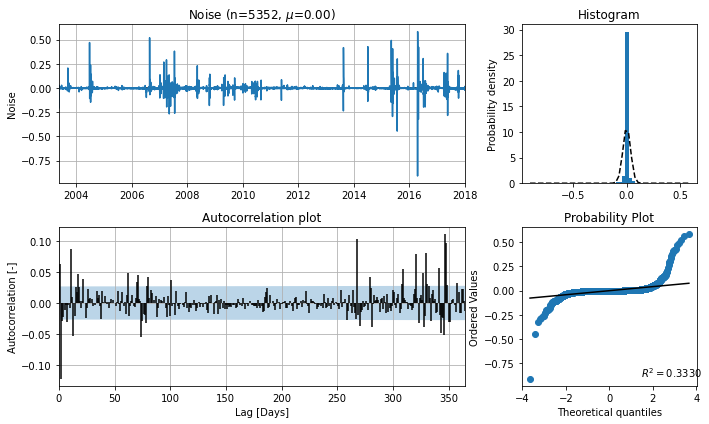

In [9]:
# diagnostic plots
ml_lwph4b.plots.diagnostics()
ml_lwph4b.stats.diagnostics()

## Separate models for wet and dry regimes

Separate data into wet and dry regimes and model separately

In [10]:
# identify wet and dry separately
lwph4b_wet = hydrodata["LWPH4b"].select(hydrodata["regime_category"] == "Wet")

AttributeError: 'Series' object has no attribute 'select'